In [10]:
TRAIN_DIR = "D:\Spring23\CVPR[B]\Assignment\Final/1/train"
TEST_DIR = "D:\Spring23\CVPR[B]\Assignment\Final/1/test"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [33]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 16

D:\Spring23\CVPR[B]\Assignment\Final/1/train//without_mask/*.jpg
D:\Spring23\CVPR[B]\Assignment\Final/1/train//with_mask/*.jpg


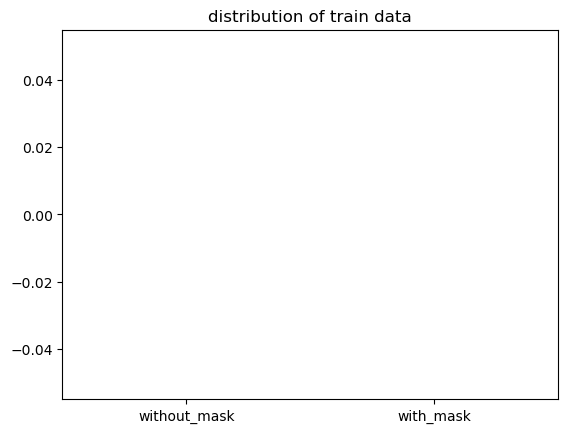

0


In [22]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))     # glob is not working
    categories.append(f)
    print(str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)


In [12]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)


In [34]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 1078 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [35]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [36]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                           

In [25]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [20]:
# Training of base_model = False
h = model.fit(
    train_batch,
    steps_per_epoch = 1078 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=268  // BATCH_SIZE,
)

67/67 [==============================] - 110s 2s/step - loss: 0.8302 - accuracy: 0.5085 - val_loss: 0.6710 - val_accuracy: 0.6562


In [26]:
# Training of base_model = True
h2 = model.fit(
    train_batch,
    steps_per_epoch = 1078 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=268  // BATCH_SIZE,
)

67/67 [==============================] - 110s 2s/step - loss: 3.2087 - accuracy: 0.5179 - val_loss: 0.6727 - val_accuracy: 0.5547


### After training a dataset with MobileNet, two validation accuracies were obtained. The first accuracy, obtained through freezed base model, was 65%. This means that MobileNet was trained with pre-existing weights and only the top layers were trained on the specific dataset. On the other hand, the second accuracy, obtained through unfreezed base model, was 55%. This means that all layers in MobileNet were trained on the specific dataset. The difference in accuracies between the two methods can be attributed to overfitting, where the model may have memorized the training data too well and failed to generalize to new data.